In [1]:
import json
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
plt.style.use("ggplot")
plt.rcParams["figure.figsize"] = [12, 8]
matplotlib.rcParams.update({
    'font.size': 15,
    "xtick.color": "#333333",
    "ytick.color": "#333333",
    "axes.facecolor": "white",
    "axes.edgecolor": "darkgrey",
    "axes.labelcolor": "darkgrey",
})

In [4]:
df = pd.read_csv('data/prepped/spotify_full.csv')
dfprepped = pd.read_csv('data/prepped/spotify_featured.csv')

In [5]:
with open(f'data/output/model_outputs_20210308071110.json', 'r') as stream:
    model_comparison = json.load(stream)

In [6]:
df['nyear'] = None
df.loc[lambda x: x['year']=='60s', 'nyear'] = 1
df.loc[lambda x: x['year']=='70s', 'nyear'] = 2
df.loc[lambda x: x['year']=='80s', 'nyear'] = 3
df.loc[lambda x: x['year']=='90s', 'nyear'] = 4
df.loc[lambda x: x['year']=='00s', 'nyear'] = 5
df.loc[lambda x: x['year']=='10s', 'nyear'] = 6

## 0. CHECK VARIABLES

In [7]:
for v in [x for x in dfprepped.columns if x not in ['target']]:
    print(f'- {v} ==> min-median-max: {round(dfprepped[v].min(), 2)} - {round(dfprepped[v].median(), 2)} - {round(dfprepped[v].max(), 2)}')

- danceability ==> min-median-max: 0.0 - 0.55 - 0.99
- energy ==> min-median-max: 0.0 - 0.6 - 1.0
- key ==> min-median-max: 0 - 5.0 - 11
- loudness ==> min-median-max: -49.25 - -9.26 - 3.74
- mode ==> min-median-max: 0 - 1.0 - 1
- speechiness ==> min-median-max: 0.0 - 0.04 - 0.96
- acousticness ==> min-median-max: 0.0 - 0.26 - 1.0
- instrumentalness ==> min-median-max: 0.0 - 0.0 - 1.0
- liveness ==> min-median-max: 0.01 - 0.13 - 1.0
- valence ==> min-median-max: 0.0 - 0.56 - 1.0
- tempo ==> min-median-max: 0.0 - 117.56 - 241.42
- duration_ms ==> min-median-max: 15168 - 217907.0 - 4170227
- time_signature ==> min-median-max: 0 - 4.0 - 5
- chorus_hit ==> min-median-max: 0.0 - 35.85 - 433.18
- sections ==> min-median-max: 0 - 10.0 - 169
- n_artist_tracks ==> min-median-max: 1 - 8.0 - 207


## 1. STATISTICS

In [8]:
dftotals = df.groupby(['nyear', 'year', 'target'], as_index=False)[['track']].count()
dftotals.columns = ['nyear', 'year', 'target', 'n_tracks']

dftotals['n_hits'] = None
dftotals.loc[lambda x: x['target']==1, 'n_hits'] = dftotals.loc[lambda x: x['target']==1]['n_tracks']
dftotals['n_hits'] = dftotals['n_hits'].fillna(0)
dftotals['n_flops'] = None
dftotals.loc[lambda x: x['target']==0, 'n_flops'] = dftotals.loc[lambda x: x['target']==0]['n_tracks']
dftotals['n_flops'] = dftotals['n_flops'].fillna(0)

dftotals_t = dftotals.groupby(['nyear', 'year'], as_index=False)[['n_hits', 'n_flops']].sum()

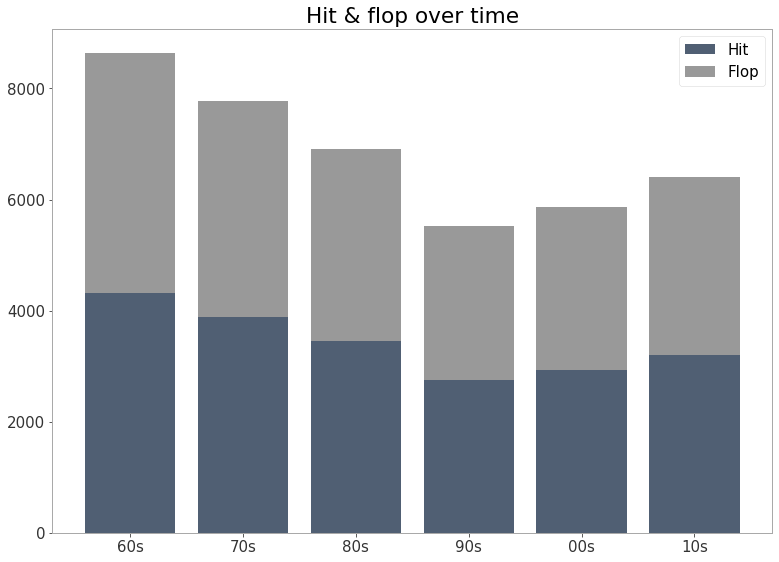

In [9]:
fig = plt.figure(figsize=(10,7))
ax = fig.add_axes([0,0,1,1])
ax.bar(dftotals_t['year'], dftotals_t['n_hits'], color='#505F73')
ax.bar(dftotals_t['year'], dftotals_t['n_flops'], color='#999999', bottom=dftotals_t['n_hits'])
ax.legend(labels=['Hit', 'Flop'])
plt.title('Hit & flop over time')
plt.show()

In [10]:
df['n_artist_tracks'] = df.groupby('artist')['track'].transform('count')
dfartist = df.groupby('artist', as_index=False)[['track']].count()
dfartist.columns = ['artist', 'n_artist_tracks']

<Figure size 720x504 with 0 Axes>

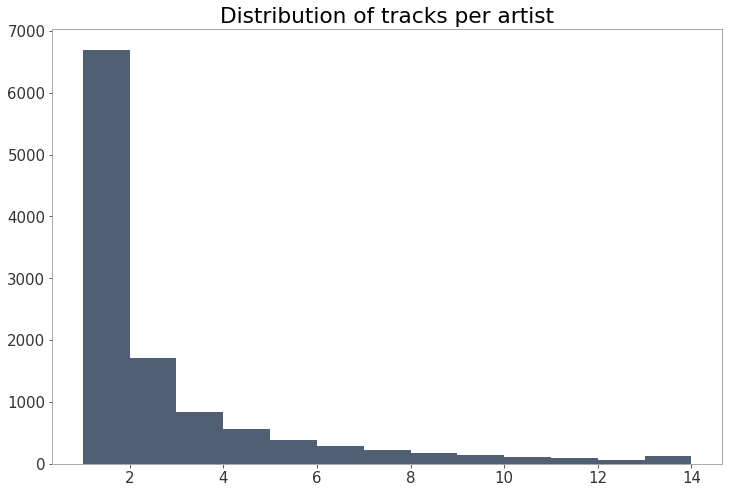

In [11]:
nmax = 15
fig = plt.figure(figsize=(10,7))
dfartist.loc[lambda x: x['n_artist_tracks']<nmax].hist(bins=range(1, nmax), color='#505F73')
plt.title('Distribution of tracks per artist')
plt.show()

In [12]:
dftrackartist = dfartist.groupby('n_artist_tracks')[['artist']].count()
dftrackartist['ntrack_share'] = dftrackartist['artist'] / dftrackartist['artist'].sum()
dftrackartist[:3]

,artist,ntrack_share
n_artist_tracks,,
1,6698,0.562668
2,1703,0.143061
3,835,0.070144


In [13]:
round(1 - dftrackartist[:20]['ntrack_share'].sum(), 5)*100

2.352

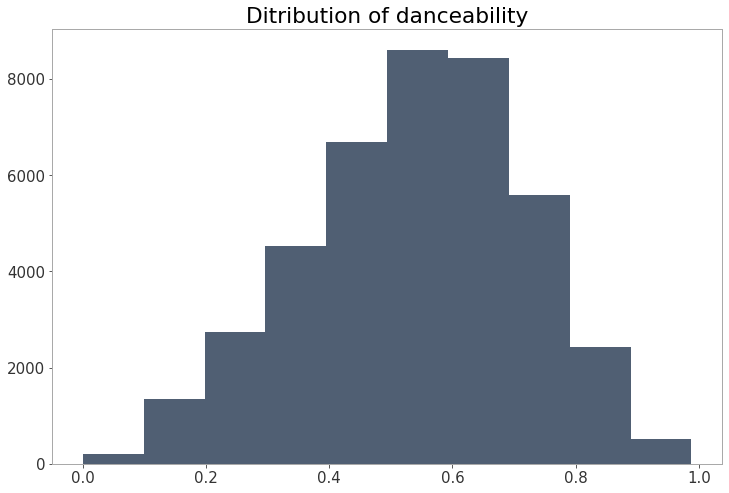

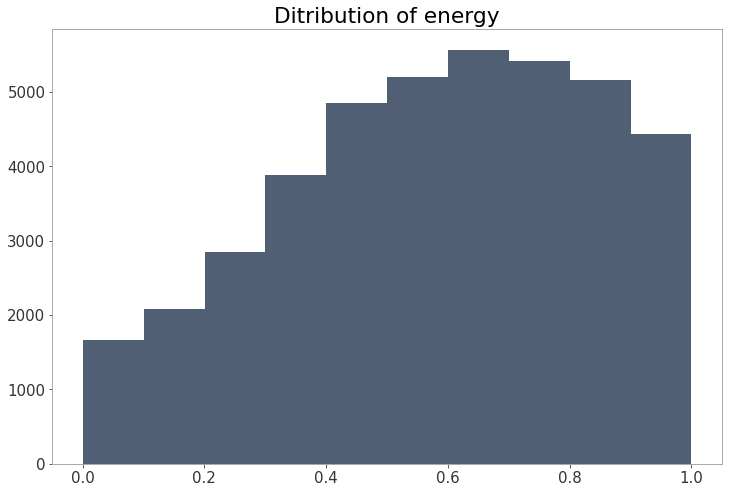

In [14]:
for v in [x for x in dfprepped.columns if x not in 'target'][:2]:
    df[v].hist(color='#505F73')
    plt.title(f'Ditribution of {v}')
    plt.show()

In [15]:
dfpie = df.groupby('mode', as_index=False)[['target']].count()

dfpie.loc[lambda x: x['mode']==0, 'mode'] = 'Minor'
dfpie.loc[lambda x: x['mode']==1, 'mode'] = 'Major'

dfpie['n_track_share'] = dfpie['target'] / dfpie['target'].sum()

dfpie.index = dfpie['mode']

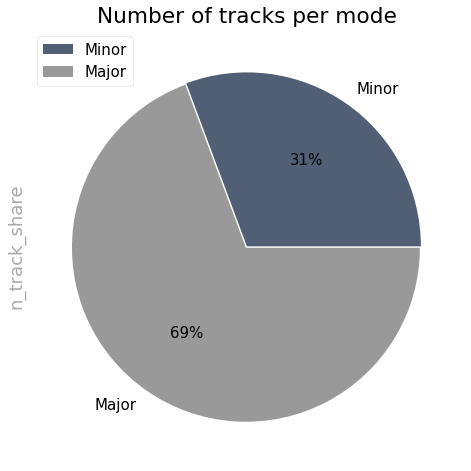

In [16]:
explode = [0, 0.01]
dfpie.plot.pie(y='n_track_share', colors=['#505F73', '#999999'], explode=explode, autopct='%1.0f%%')
plt.title('Number of tracks per mode')
plt.show()

## 2. ANALYTICS

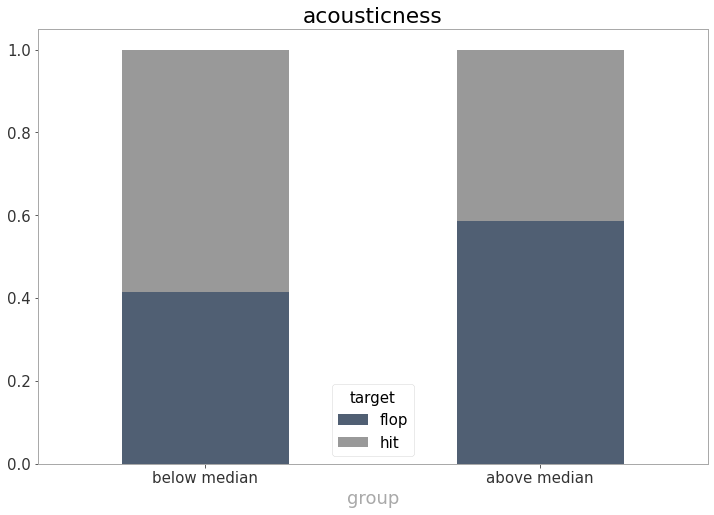

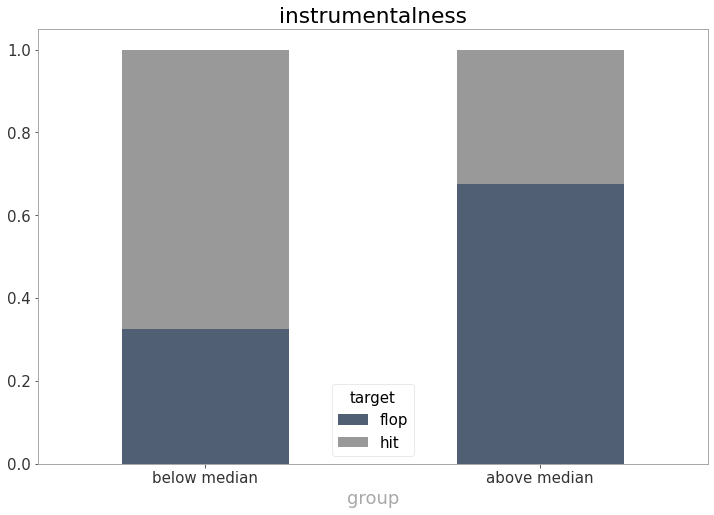

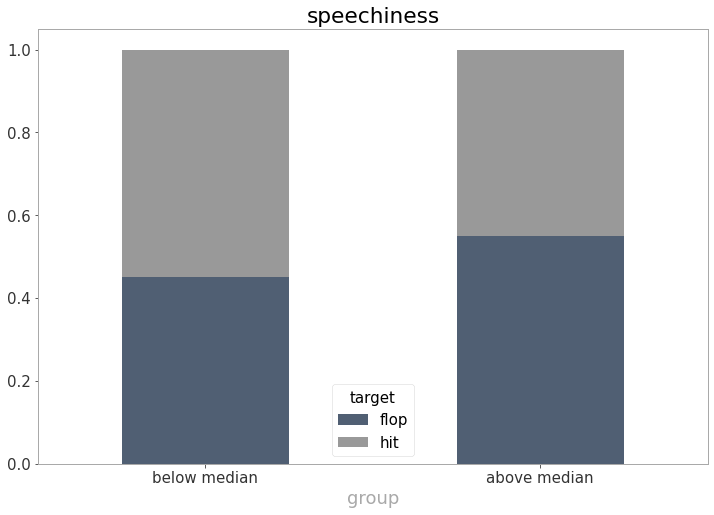

In [17]:
# for v in [x for x in dfprepped.columns if x not in 'target'][:2]:
for v in ['acousticness', 'instrumentalness', 'speechiness']:
    
    median = dfprepped[v].median()
    dfprepped['group'] = 'below median'
    dfprepped.loc[lambda x: x[v]>median, 'group'] = 'above median'
    dfprepped.loc[lambda x: x['target']==0, 'target'] = 'flop'
    dfprepped.loc[lambda x: x['target']==1, 'target'] = 'hit'
    
    crosstab = pd.crosstab(dfprepped['group'], dfprepped['target'])
    crosstab_percent = crosstab.div(crosstab.sum(axis=1), axis=0)
    crosstab_percent = crosstab_percent.reindex(index=crosstab_percent.index[::-1])
    crosstab_percent.plot.bar(stacked=True, color=['#505F73', '#999999'], rot=0)
    
    plt.title(v)
    plt.show()

In [18]:
dfprepped['duration_seconds'] = dfprepped['duration_ms'] / 1000

In [19]:
dfprepped['duration_group'] = '1. < 100'
dfprepped.loc[lambda x: x['duration_seconds']>100, 'duration_group'] = '2. 100-199'
dfprepped.loc[lambda x: x['duration_seconds']>200, 'duration_group'] = '3. 200-299'
dfprepped.loc[lambda x: x['duration_seconds']>300, 'duration_group'] = '4. 300-399'
dfprepped.loc[lambda x: x['duration_seconds']>400, 'duration_group'] = '5. 400-499'
dfprepped.loc[lambda x: x['duration_seconds']>500, 'duration_group'] = '6. >= 500'

Text(0.5, 1.0, 'Duration in seconds - hit/flop split')

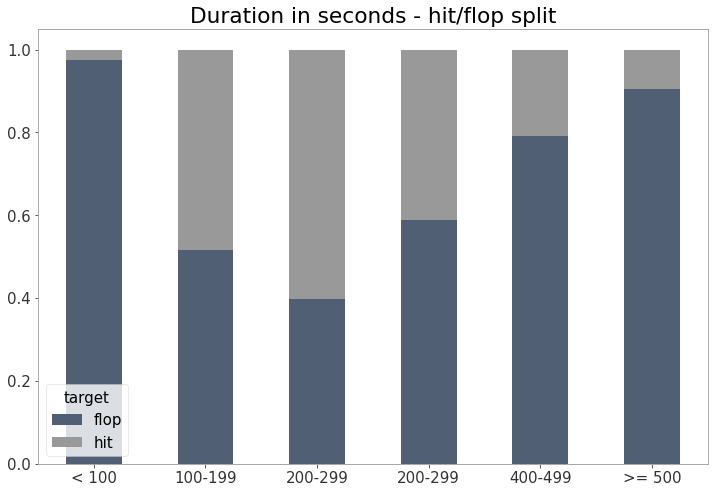

In [20]:
crosstab = pd.crosstab(dfprepped['duration_group'], dfprepped['target'])
crosstab_percent = crosstab.div(crosstab.sum(axis=1), axis=0)
crosstab_percent.index = ['< 100', '100-199', '200-299', '200-299', '400-499', '>= 500']
crosstab_percent.plot.bar(stacked=True, color=['#505F73', '#999999'], rot=0)
plt.title('Duration in seconds - hit/flop split')

In [22]:
dfartist['artist'].count()

11904